In [1]:
import numpy as np
import pandas as pd

import pandas_profiling
from pandas_profiling.utils.cache import cache_file
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

**Created directory structure for the project using cookiecutter**

In [2]:
%%time
file_dir = "../data/raw/"
train_df = pd.read_csv(file_dir + "train.csv")
building_metadata_df = pd.read_csv(file_dir + "building_metadata.csv")
weather_test_df = pd.read_csv(file_dir + "weather_test.csv")
weather_train_df = pd.read_csv(file_dir + "weather_train.csv")
test_df = pd.read_csv(file_dir + "test.csv")
sample_submission_df = pd.read_csv(file_dir + "sample_submission.csv")
!ls ../data/raw

ashrae-energy-prediction.zip train.csv
building_metadata.csv        weather_test.csv
sample_submission.csv        weather_train.csv
test.csv
CPU times: user 26.7 s, sys: 9.1 s, total: 35.8 s
Wall time: 44.9 s


#### Check sizes of the different dfs

In [3]:
print('train_df size is {} & memory used is {:.2f}Mb\nbuilding_metadata_df size is {} & memory used is {:.2f}Mb\
\nweather_test_df size is{} & memory used is {:.2f}Mb\nweather_train_df size is {} & memory used is {:.2f}Mb\
\ntest_df size is {} & memory used is {:.2f}Mb\nsample_submission_df size is{} & memory used is {:.2f}Mb'.\
      format(train_df.shape,train_df.memory_usage().sum()/1024**2,
             building_metadata_df.shape,building_metadata_df.memory_usage().sum()/1024**2,
             weather_test_df.shape,weather_test_df.memory_usage().sum()/1024**2,
             weather_train_df.shape,weather_train_df.memory_usage().sum()/1024**2,
            test_df.shape,test_df.memory_usage().sum()/1024**2,
             sample_submission_df.shape,sample_submission_df.memory_usage().sum()/1024**2))

train_df size is (20216100, 4) & memory used is 616.95Mb
building_metadata_df size is (1449, 6) & memory used is 0.07Mb
weather_test_df size is(277243, 9) & memory used is 19.04Mb
weather_train_df size is (139773, 9) & memory used is 9.60Mb
test_df size is (41697600, 4) & memory used is 1272.51Mb
sample_submission_df size is(41697600, 2) & memory used is 636.26Mb


## Train df 

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   building_id    int64  
 1   meter          int64  
 2   timestamp      object 
 3   meter_reading  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


In [5]:
train_df.meter.unique()

array([0, 3, 1, 2])

**Meter column should be of the dtype Category**

In [6]:
train_df['meter'] = train_df['meter'].astype('category')

**timestamp column should be of the dtype timestamp and not str**

In [7]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    int64         
 1   meter          category      
 2   timestamp      datetime64[ns]
 3   meter_reading  float64       
dtypes: category(1), datetime64[ns](1), float64(1), int64(1)
memory usage: 482.0 MB


In [9]:
if train_df.building_id.max() < np.iinfo(np.int16).max and train_df.building_id.min() > np.iinfo(np.int16).min:
    print("building_id can be converted to int16 instead of int64")

building_id can be converted to int16 instead of int64


In [10]:
train_df['building_id'] = train_df['building_id'].astype('int16')

In [11]:
train_df.agg([min,"mean","median",max]).T

,min,mean,median,max
building_id,0,799.278,895,1448
timestamp,2016-01-01 00:00:00,2016-07-03 22:59:40.301601792,NaT,2016-12-31 23:00:00
meter_reading,0,2117.12,78.775,2.19047e+07


**For meter_reading since the median is ~78 , there are some outliers at the higher range.**

In [12]:
#train_df_report = train_df.profile_report(sort='None', html={'style':{'full_width': True}}, progress_bar=True)
#train_df_report
#Did not find profiling very useful for this dataset

#train_df_profile_report = train_df.profile_report(html={'style': {'full_width': True}})
#train_df_profile_report.to_file("../reports/train_df_profile_report.html")

**Meter category - {0:Electtricity,1:ChilledWater,2:Steam,3:HotWater}**

[None]

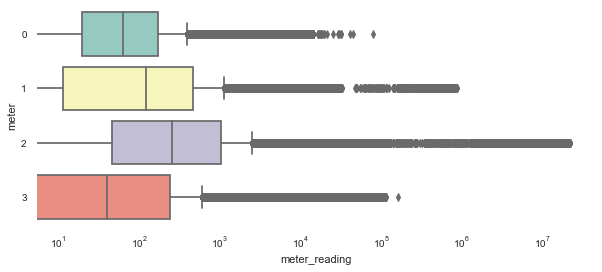

In [13]:
plt.figure(figsize=(10, 4))
meter_rd_boxplt = sns.boxplot(data=train_df,x="meter_reading",y="meter",palette="Set3")
meter_rd_boxplt.set(xscale="log")

## building_metadata_df

In [15]:
building_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   int64  
 1   building_id  1449 non-null   int64  
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   int64  
 4   year_built   675 non-null    float64
 5   floor_count  355 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [16]:
building_metadata_df['site_id'] = building_metadata_df['site_id'].astype('int16')

In [17]:
building_metadata_df['building_id'] = building_metadata_df['building_id'].astype('int16')

In [18]:
building_metadata_df.primary_use.unique()

array(['Education', 'Lodging/residential', 'Office',
       'Entertainment/public assembly', 'Other', 'Retail', 'Parking',
       'Public services', 'Warehouse/storage', 'Food sales and service',
       'Religious worship', 'Healthcare', 'Utility', 'Technology/science',
       'Manufacturing/industrial', 'Services'], dtype=object)

**Primary use column should be of type category**

In [19]:
building_metadata_df['primary_use'] = building_metadata_df['primary_use'].astype('category')

In [20]:
building_metadata_df['primary_use'].describe()

count          1449
unique           16
top       Education
freq            549
Name: primary_use, dtype: object

**#Convert Year to Datetime format for better time-series-analysis**

In [21]:
#building_metadata_df['year_built']=building_metadata_df['year_built'].astype(str)
#building_metadata_df['year_built']=building_metadata_df['year_built'].str.rstrip(".0")
#building_metadata_df['year_built']=pd.to_datetime(building_metadata_df['year_built'],infer_datetime_format=True,errors='coerce')

**Missing Data analysis for year_built & floor_count**

<Figure size 144x144 with 0 Axes>

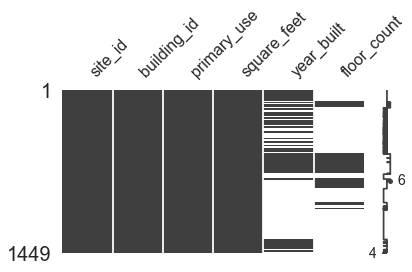

In [22]:
#Check if year_built is missing for a particular site_id or building_id
import missingno as msno
plt.figure(figsize=(2, 2))
msno_mat=msno.matrix(building_metadata_df.sort_values("site_id"),figsize=(6,3))

In [23]:
building_metadata_df[building_metadata_df['year_built'].isnull()].site_id.value_counts().head(5)

13    154
3     142
9     124
14    102
8      70
Name: site_id, dtype: int64

In [24]:
building_metadata_df[building_metadata_df['year_built'].isnull()].building_id.value_counts().head(5)

1023    1
1313    1
1287    1
1286    1
261     1
Name: building_id, dtype: int64

In [25]:
building_metadata_df[building_metadata_df['year_built'].isnull()].primary_use.value_counts().head(5)

Education                        223
Office                           194
Entertainment/public assembly    111
Public services                  105
Lodging/residential               62
Name: primary_use, dtype: int64

In [26]:
bd_mt_flrcnt_null_df = building_metadata_df[building_metadata_df['floor_count'].isnull()]
bd_mt_flrcnt_null_df.groupby(['site_id','primary_use']).size().sort_values().tail(10)

site_id  primary_use                  
15       Lodging/residential              29
0        Education                        30
14       Office                           38
3        Entertainment/public assembly    44
15       Education                        46
2        Education                        61
9        Education                        63
13       Office                           75
3        Public services                  86
         Education                        92
dtype: int64

**Since too many buildings have year_built NaN we are going to leave the column as is**

**Same is the case with floor_count**

In [27]:
#building_metadata_df['flr_cnt']=building_metadata_df.groupby(['site_id','primary_use'])['floor_count']\
#.transform(lambda grp : grp.fillna(grp.mean(skipna=True)))

In [28]:
#building_metadata_df.drop(labels='flr_cnt',axis=1)
#building_metadata_df['flr_cnt'].isnull().sum()

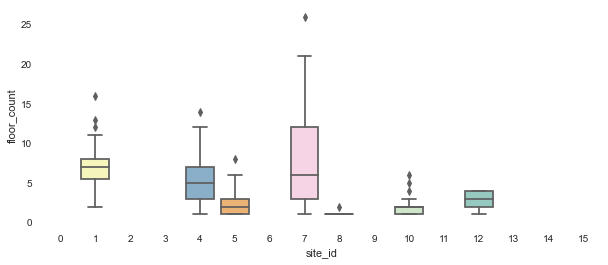

In [29]:
plt.figure(figsize=(10, 4))
floor_cnt_boxplt = sns.boxplot(data=building_metadata_df,x="site_id",y="floor_count",palette="Set3")

## weather_train_df

In [31]:
weather_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             139773 non-null  int64  
 1   timestamp           139773 non-null  object 
 2   air_temperature     139718 non-null  float64
 3   cloud_coverage      70600 non-null   float64
 4   dew_temperature     139660 non-null  float64
 5   precip_depth_1_hr   89484 non-null   float64
 6   sea_level_pressure  129155 non-null  float64
 7   wind_direction      133505 non-null  float64
 8   wind_speed          139469 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB


In [32]:
#Make sure no duplicate entries for site and timestamp
weather_train_df[['site_id','timestamp']].duplicated().sum()

0

In [33]:
weather_train_df['site_id'] = weather_train_df['site_id'].astype('int16')

In [34]:
weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])

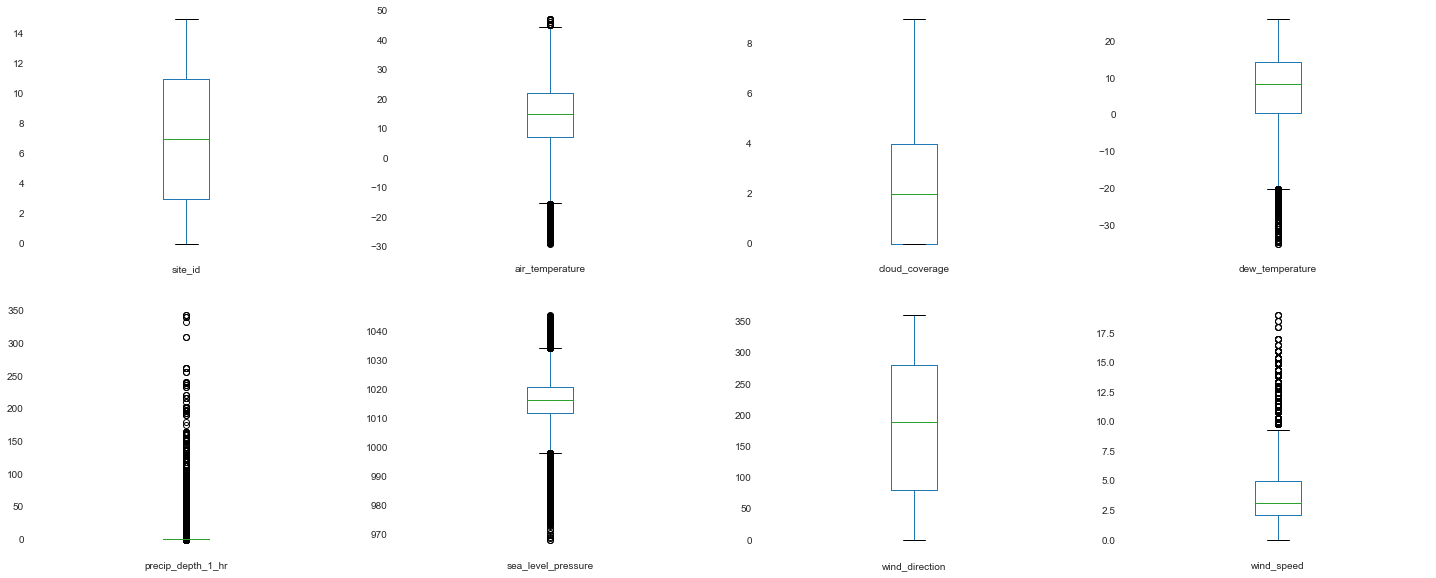

In [35]:
weather_train_df.plot(kind='box', subplots=True, layout=(2,4),figsize=(25,10))
plt.show()

In [36]:
import missingno as msno
plt.figure(figsize=(2, 2))

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

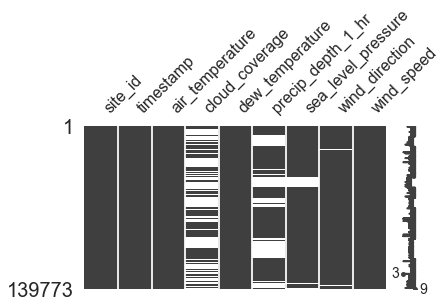

In [37]:
msno_mat=msno.matrix(weather_train_df,figsize=(6,3))

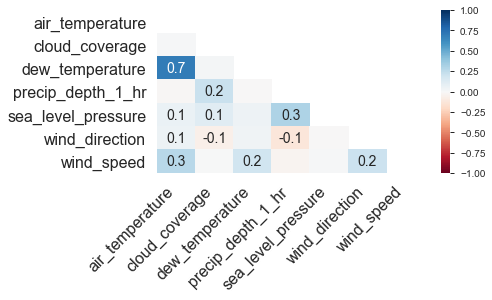

In [38]:
msno_mat=msno.heatmap(weather_train_df,figsize=(6,3))

**dew_temperature and air_temperature are highly correlated , i.e , one is present then the value of the other is definitely present.

In [39]:
(weather_train_df.isnull().sum()/weather_train_df.count().max()*100).sort_values()

site_id                0.000000
timestamp              0.000000
air_temperature        0.039350
dew_temperature        0.080845
wind_speed             0.217496
wind_direction         4.484414
sea_level_pressure     7.596603
precip_depth_1_hr     35.979052
cloud_coverage        49.489529
dtype: float64

**Lets plot the 'air_temperature','dew_temperature','wind_direction' graph over a period of time with monthly average temperatures**

Text(0, 0.5, 'wind_speed')

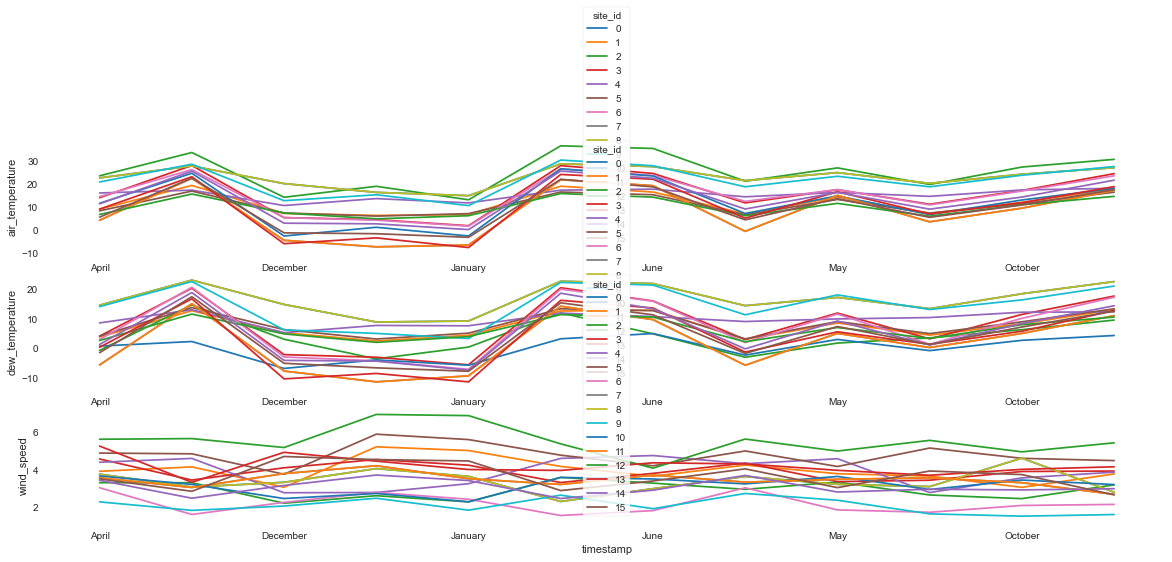

In [40]:
# plot data
fig, ax = plt.subplots(3,1,figsize=(20,7))
# use unstack()
weather_train_df.groupby([weather_train_df['timestamp'].dt.strftime('%B'),'site_id']).agg("mean")['air_temperature'].unstack().plot(ax=ax[0])
weather_train_df.groupby([weather_train_df['timestamp'].dt.strftime('%B'),'site_id']).agg("mean")['dew_temperature'].unstack().plot(ax=ax[1])
weather_train_df.groupby([weather_train_df['timestamp'].dt.strftime('%B'),'site_id']).agg("mean")['wind_speed'].unstack().plot(ax=ax[2])
ax[0].set_ylabel("air_temperature")
ax[1].set_ylabel("dew_temperature")
ax[2].set_ylabel("wind_speed")

**Let's analyse one site's 'air_temperature','dew_temperature','wind_direction' fluctuation over a period of a day.**


Text(0, 0.5, 'wind_speed')

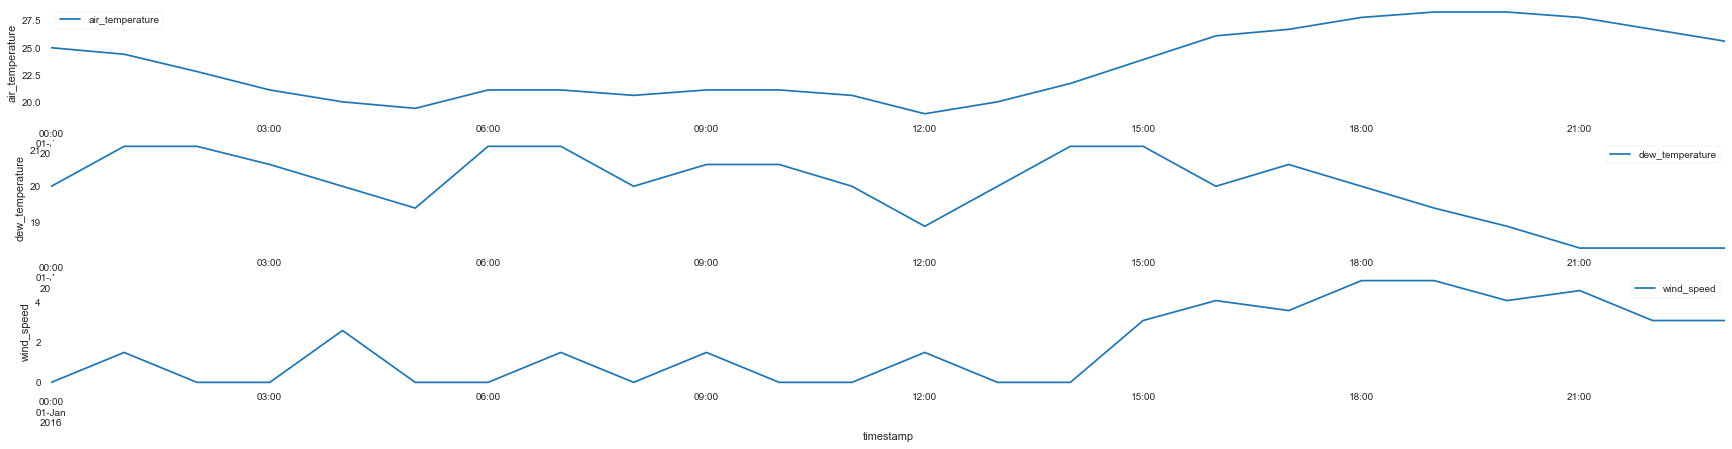

In [41]:
fig, ax = plt.subplots(3,1,figsize=(20,7))
weather_train_df[(weather_train_df.site_id==0) & (weather_train_df.timestamp.dt.strftime('%Y-%m-%d') == '2016-01-01')].plot(x='timestamp',y='air_temperature',figsize=(30,7),ax=ax[0])
weather_train_df[(weather_train_df.site_id==0) & (weather_train_df.timestamp.dt.strftime('%Y-%m-%d') == '2016-01-01')].plot(x='timestamp',y='dew_temperature',figsize=(30,7),ax=ax[1])
weather_train_df[(weather_train_df.site_id==0) & (weather_train_df.timestamp.dt.strftime('%Y-%m-%d') == '2016-01-01')].plot(x='timestamp',y='wind_speed',figsize=(30,7),ax=ax[2])
ax[0].set_ylabel("air_temperature")
ax[1].set_ylabel("dew_temperature")
ax[2].set_ylabel("wind_speed")

In [42]:
weather_train_df[weather_train_df[['air_temperature','dew_temperature','wind_speed']].isna().any(axis=1)]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
368,0,2016-01-16 08:00:00,NaN,NaN,NaN,0.0,NaN,180.0,1.5
369,0,2016-01-16 09:00:00,NaN,2.0,NaN,0.0,NaN,190.0,1.5
370,0,2016-01-16 10:00:00,NaN,2.0,NaN,0.0,NaN,190.0,1.5
15763,1,2016-10-18 13:00:00,NaN,NaN,NaN,NaN,NaN,290.0,6.2
21143,2,2016-05-29 20:00:00,33.3,0.0,-1.1,0.0,1009.5,NaN,NaN
...,...,...,...,...,...,...,...,...,...
137333,15,2016-09-19 17:00:00,22.8,4.0,18.3,NaN,1017.8,NaN,NaN
137338,15,2016-09-19 22:00:00,24.4,4.0,15.6,NaN,1017.9,NaN,NaN
137849,15,2016-10-11 14:00:00,7.8,0.0,2.2,NaN,1031.9,NaN,NaN
138046,15,2016-10-19 20:00:00,17.8,4.0,10.6,NaN,NaN,NaN,NaN


**Since 'air_temperature','dew_temperature','wind_direction' can fluctuate even in a day. 
Hence we can interpolate the values linearly to fill na values**

In [43]:
#weather_train_df['air_temperature']=weather_train_df.sort_values(['site_id','timestamp'])['air_temperature'].interpolate()
weather_train_df[['air_temperature','dew_temperature','wind_speed']]=weather_train_df.sort_values('timestamp').groupby('site_id')[['air_temperature','dew_temperature','wind_speed']].apply(lambda grp : grp.interpolate())
#Commented the first interpolate as it needs to be within each group.

In [44]:
weather_train_df[weather_train_df[['air_temperature','dew_temperature','wind_speed']].isna().any(axis=1)]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed


***Removing outliers***

In [45]:
#Lets work with columns with possible outliers (Remove site_id,timestamp)
#outliers_df = weather_train_df[weather_train_df.columns[~weather_train_df.columns.isin(['air_temperature','dew_temperature','wind_speed'])]]
outliers_df = weather_train_df[['air_temperature','dew_temperature','wind_speed']]
Q1 = outliers_df.quantile(0.25)
Q3 = outliers_df.quantile(0.75)
IQR = Q3 - Q1
outliers_df[~((outliers_df < (Q1 - 1.5 * IQR)) |(outliers_df > (Q3 + 1.5 * IQR))).any(axis=1)]
#for i in weather_train_df.columns[~weather_train_df.columns.isin(['site_id','timestamp'])]:
#    Q1 = weather_train_df[i].quantile(0.25)
#    Q3 = weather_train_df[i].quantile(0.75)
#    IQR = Q3 - Q1
#    print(i)
#    print(weather_train_df[((weather_train_df[i] < (Q1 - 3.5 * IQR)) |(weather_train_df[i] > (Q3 + 3.5 * IQR)))][i].count())

,air_temperature,dew_temperature,wind_speed
0,25.0,20.0,0.0
1,24.4,21.1,1.5
2,22.8,21.1,0.0
3,21.1,20.6,0.0
4,20.0,20.0,2.6
...,...,...,...
139768,3.0,-8.0,5.7
139769,2.8,-8.9,7.7
139770,2.8,-7.2,5.1
139771,2.2,-6.7,4.6


**Too many outliers to delete entire rows**